# System analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### 1) Load data from BIN files

In [2]:
### Load data from disk
import pickle
with open('aida_agdistis.bin', 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('wes2015_agdistis.bin', 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('aida_spotlight.bin', 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('wes2015_spotlight.bin', 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
    
wes_title='wes2015'
aida_title='aida'

#### DEBUG: Store agdistis output to a file

In [3]:
"""
with open('agdistis_aida_debug.tsv', 'w') as w:
    w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
    for article in aida_agd_articles:
        for mention in article.entity_mentions:
            a_row=[article.collection, str(article.identifier), 
                   str(mention.begin_index), str(mention.end_index), 
                   mention.mention, mention.gold_link, 
                   mention.sys_link]
            w.write('\t'.join(a_row) + '\n')
"""

"\nwith open('agdistis_aida_debug.tsv', 'w') as w:\n    w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')\n    for article in aida_agd_articles:\n        for mention in article.entity_mentions:\n            a_row=[article.collection, str(article.identifier), \n                   str(mention.begin_index), str(mention.end_index), \n                   mention.mention, mention.gold_link, \n                   mention.sys_link]\n            w.write('\t'.join(a_row) + '\n')\n"

In [4]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [9]:
print(type(aida_agd_articles))
spot_articles=aida_spot_articles.union(wes_spot_articles)
agd_articles=aida_agd_articles.union(wes_agd_articles)
#print(len(articles))
skip_nils=True
skip_nonnils=False

<class 'set'>


### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [10]:
scores=[]
systems=['agdistis', 'spotlight']
system_articles = {'agdistis': agd_articles, 'spotlight': spot_articles}

In [11]:
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils, skip_nonnils)
scores.append(['overall', 'agdistis', agd_acc])
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils, skip_nonnils)
print(spot_acc)
scores.append(['overall', 'spotlight', spot_acc])


AGDISTIS
26695 56404
0.4732820367349833

SPOTLIGHT
38180 56404
0.6769023473512517


#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [13]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [14]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_acc_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1120 3061
agdistis 0.3658934988565828
1413 3061
spotlight 0.4616138516824567


#### 2.4. Only ambiguous forms

In [15]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_acc_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    scores.append(['ambiguous forms', system, amb_f_acc])

5284 14804
agdistis 0.35693055930829504
8660 14804
spotlight 0.584977033234261


In [16]:
scores

[['overall', 'agdistis', 0.4732820367349833],
 ['overall', 'spotlight', 0.6769023473512517],
 ['forms with nils & non-nils', 'agdistis', 0.3658934988565828],
 ['forms with nils & non-nils', 'spotlight', 0.4616138516824567],
 ['ambiguous forms', 'agdistis', 0.35693055930829504],
 ['ambiguous forms', 'spotlight', 0.584977033234261]]

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight']
width: 0.19999999999999998
evaluation: overall
evaluation: ambiguous forms
evaluation: forms with nils & non-nils


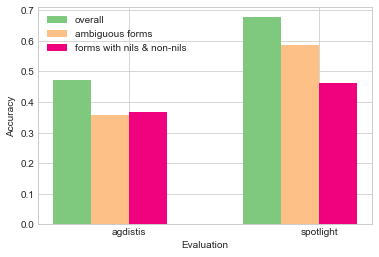

In [17]:
plot_utils.plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [18]:
from scipy.stats import pearsonr, spearmanr

In [22]:
acc_by_form = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

In [49]:
import math

def counts_to_log_counts(forms_by_count):
    forms_by_log_count={}
    for count, forms in forms_by_count.items():
        try:
            log_count=round(math.log(count), 2)
        except:
            print(count)
        forms_by_log_count[log_count] = forms
    return forms_by_log_count

forms_by_log_count=counts_to_log_counts(forms_by_count)

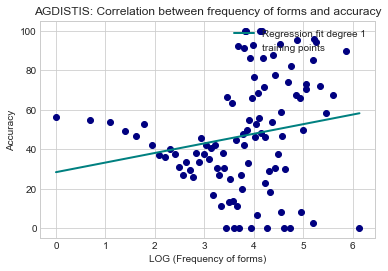

The Spearman correlation between X and Y is: 0.272757022535 . Significance:  0.00604112063743


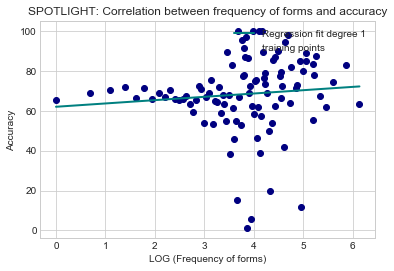

The Spearman correlation between X and Y is: 0.235771357719 . Significance:  0.0182028774668


In [40]:
from collections import OrderedDict
import numpy as np

acc_by_freq={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(forms_by_log_count.keys()):
        count_forms=forms_by_log_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of forms and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of forms)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 4) Entropy

In [38]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(spot_articles, form)
    counts=list(counts)
    form_entropies[form]=entropy(counts,base=len(counts))

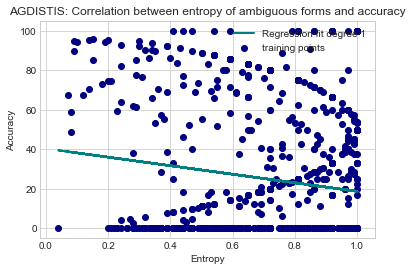

The Spearman correlation between X and Y is: -0.159080179605 . Significance:  2.31881249876e-07


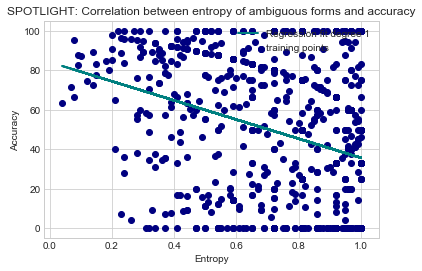

The Spearman correlation between X and Y is: -0.333191685689 . Significance:  1.54521475569e-28


In [39]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(round(form_entropies[f], 2))
        dist2.append(acc_by_form[system][f])

    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between entropy of ambiguous forms and accuracy' % system.upper(),
                            x_axis='Entropy',
                            y_axis='Accuracy',
                            save=True
                            )

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [41]:
acc_by_uri = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

In [42]:
uris_by_log_count=counts_to_log_counts(uris_by_count)

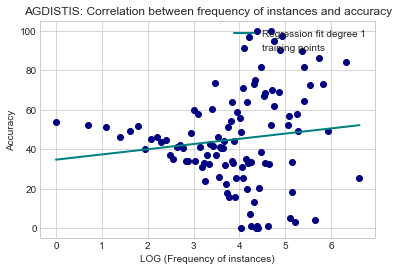

The Spearman correlation between X and Y is: 0.153566197917 . Significance:  0.114284219935


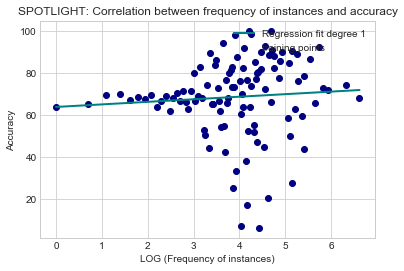

The Spearman correlation between X and Y is: 0.191937498472 . Significance:  0.0476414829004


In [44]:
acc_by_freq_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(uris_by_log_count.keys()):
        count_uris=uris_by_log_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of instances and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 6) Correlation between instance PageRank and accuracy

In [46]:
skip_zeros=True

In [51]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in spot_articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            if skip_zeros and pagerank==0: continue
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

In [52]:
uris_by_log_pr=counts_to_log_counts(uris_by_pr)

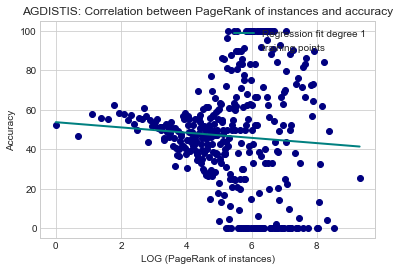

The Spearman correlation between X and Y is: -0.0436611560795 . Significance:  0.40688757641


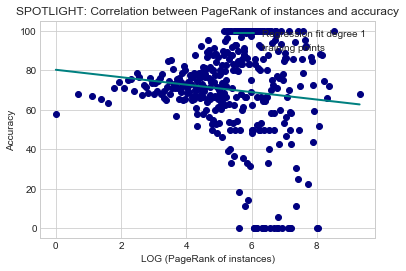

The Spearman correlation between X and Y is: 0.0125191604987 . Significance:  0.812107037398


In [54]:
acc_by_pr_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for pr in sorted(uris_by_log_pr.keys()):


        count_uris=uris_by_log_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between PageRank of instances and accuracy' % system.upper(),
                            x_axis='LOG (PageRank of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [55]:
interpretations=defaultdict(set)
for article in spot_articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [56]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [57]:
len(ambiguity)

19280

defaultdict(<class 'int'>, {1: 11410, 2: 2536, 3: 458, 4: 118, 5: 32, 6: 13, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.4127957931638913, 2: 0.1857255520504732, 3: 0.10262008733624454, 4: 0.03389830508474576, 5: 0.03125, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


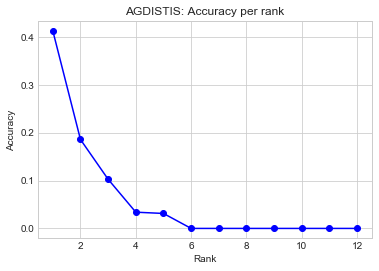

The Spearman correlation between X and Y is: -0.896769649462 . Significance:  7.74575309354e-05
defaultdict(<class 'int'>, {1: 11410, 2: 2536, 3: 458, 4: 118, 5: 32, 6: 13, 7: 4, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1})
defaultdict(<class 'float'>, {1: 0.6443470639789658, 2: 0.431782334384858, 3: 0.3384279475982533, 4: 0.3389830508474576, 5: 0.0625, 6: 0.5384615384615384, 7: 0.0, 8: 1.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


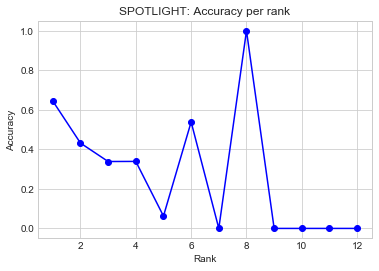

The Spearman correlation between X and Y is: -0.667104681107 . Significance:  0.0177976558063


In [59]:
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form)
#    print(correct_per_rank)
    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank' % system.upper(), save=True)
    


### 8) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


In [ ]:
# Top 10 have form frequency of >135
min_frequency=170
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, 
                                                                total_per_form, 
                                                                min_frequency=min_frequency)
#    print(correct_per_rank)
#    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank (top-N surface forms)' % system.upper(), save=True)
    


#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [ ]:
form='England'
print(total_per_form[form])
print(correct_per_form[form])

In [ ]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

#### What is going on with China?

In [ ]:
for a in spot_articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [60]:
uri_pr

{'Slovenia': 526.5209,
 'Poland': 2057.1688,
 'NATO': 411.3501,
 'Ljubljana': 107.4887,
 'European_Union': 1114.9956,
 'Aleksander_Kwaśniewski': 9.3586,
 'Milan_Kučan': 4.4466,
 'Hungary': 802.5039,
 'Slovakia': 517.617,
 'Czech_Republic': 723.149,
 'Janez_Drnovšek': 3.9368,
 'Rugby_league': 262.7735,
 'London': 2112.4877,
 'Super_League': 52.6984,
 'Paris_Saint-Germain_Rugby_League': 3.5345,
 'Bradford_Bulls': 18.7552,
 'Wigan_Warriors': 30.5535,
 'Workington_Town': 6.5769,
 'St_Helens_RFC': 26.3885,
 'Warrington_Wolves': 19.9099,
 'Wasps_RFC': 15.4715,
 'Sheffield_Eagles': 4.8377,
 'Halifax_RLFC': 15.5191,
 'Castleford_Tigers': 17.4304,
 'Oldham_Roughyeds': 12.1422,
 'Leeds_Rhinos': 27.0424,
 'July_1': 2.8892,
 '1818': 1.1395,
 'Hungarians': 217.0789,
 'Physician': 271.6874,
 'Ignaz_Semmelweis': 9.9277,
 'Puerperal_infections': 9.9544,
 'Antiseptic': 37.9834,
 'Law': 439.0322,
 'University_of_Vienna': 55.3659,
 'Medicine': 410.742,
 'Obstetrics': 46.1106,
 'Vienna_General_Hospital': 

In [61]:
acc_by_form

{'agdistis': defaultdict(int,
             {'POLISH': 0.0,
              'WARSAW': 0.0,
              'Polish': 0.0,
              'Amica Wronki': 100.0,
              'Hutnik Krakow': 100.0,
              'Lech Poznan': 100.0,
              'Rakow Czestochowa': 100.0,
              'Stomil Olsztyn': 0.0,
              'Wisla Krakow': 100.0,
              'Gornik Zabrze': 100.0,
              'Slask Wroclaw': 100.0,
              'Odra Wodzislaw': 100.0,
              'GKS Katowice': 100.0,
              'Polonia Warsaw': 100.0,
              'Zaglebie Lubin': 100.0,
              'LKS Lodz': 100.0,
              'Legia Warsaw': 100.0,
              'GKS Belchatow': 100.0,
              'Widzew Lodz': 100.0,
              'Ruch Chorzow': 100.0,
              'Austria': 77.38095238095238,
              'Brian Shimer': 100.0,
              'Shimer': 100.0,
              'Randy Jones': 0.0,
              'Olympic': 0.0,
              'Guenther Huber': 100.0,
              'Antonio Tartagl

defaultdict(<class 'int'>, {1: 4445, 2: 703, 3: 45, 4: 21, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
defaultdict(<class 'int'>, {1: 9409, 2: 3752, 3: 790, 4: 173, 5: 111, 6: 26, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.47242002338186845, 2: 0.18736673773987206, 3: 0.056962025316455694, 4: 0.12138728323699421, 5: 0.009009009009009009, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


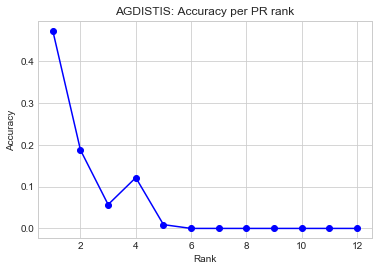

The Spearman correlation between X and Y is: -0.88897165251 . Significance:  0.000109979794947
defaultdict(<class 'int'>, {1: 6395, 2: 1889, 3: 195, 4: 57, 5: 84, 6: 13, 7: 2, 8: 0, 9: 0, 10: 0, 11: 5, 12: 0})
defaultdict(<class 'int'>, {1: 9409, 2: 3752, 3: 790, 4: 173, 5: 111, 6: 26, 7: 9, 8: 1, 9: 3, 10: 5, 11: 5, 12: 1})
defaultdict(<class 'float'>, {1: 0.6796684025932618, 2: 0.5034648187633263, 3: 0.2468354430379747, 4: 0.32947976878612717, 5: 0.7567567567567568, 6: 0.5, 7: 0.2222222222222222, 8: 0.0, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0})


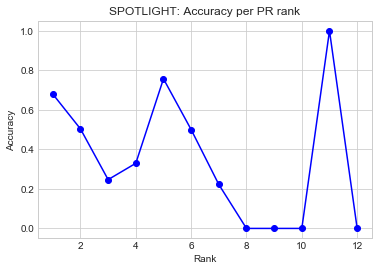

The Spearman correlation between X and Y is: -0.466265989365 . Significance:  0.126534787903


In [63]:
#acc_per_form_meaning={'agdistis': {}, 'spotlight': {}}
for system in systems:
    correct_per_rank_pr=defaultdict(int)
    total_per_rank_pr=defaultdict(int)

    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    for form, meanings in total_per_form.items():
        #for uri, total in meanings.items():
            #acc_per_form_meaning[system][form][uri]=correct_per_form[form][uri]/total
        form_pageranks=[]
        for uri in meanings.keys():
            if uri in uri_pr:
                form_pageranks.append(tuple((uri_pr[uri], uri)))
        form_pageranks = sorted(form_pageranks, reverse=True)
        for rank in range(1,len(form_pageranks)+1):
            correct_per_rank_pr[rank]+=correct_per_form[form][form_pageranks[rank-1][1]]
            total_per_rank_pr[rank]+=total_per_form[form][form_pageranks[rank-1][1]]

    print(correct_per_rank_pr)
    print(total_per_rank_pr)
    plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr, 
                          title='%s: Accuracy per PR rank' % system.upper(), save=True)


### 8) Notes

* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference